In [17]:
import re
import numpy
import pandas as pd


def parse_training_log(file):
    log_data = {
        'epoch': [],
        'type': [],
        'metric': [],
        'value': []
    }

    for line in file:
        if "Training epoch" in line:
            epoch = int(re.search(r"epoch (\d+)", line).group(1))
        elif "Epoch" in line and "on test dataset" in line:
            test_data = re.search(
                r"Epoch \d+ on test dataset: MRR: ([0-9.]+); Recalls: tensor\(\[([0-9., ]+)\]\) Loss: ([0-9.]+)positive-loss: ([0-9.]+); negative-loss: ([0-9.]+)",
                line)
            if test_data:
                mrr, recalls, loss, pos_loss, neg_loss = test_data.groups()
                recalls = recalls.split(', ')
                log_data['epoch'].extend([epoch] * 7)
                log_data['type'].extend(['test'] * 7)
                log_data['metric'].extend(['MRR', 'Recall@1', 'Recall@5', 'Recall@10',
                                           'Total Loss', 'Positive Loss', 'Negative Loss'])
                log_data['value'].extend(
                    [float(mrr), float(recalls[0]), float(recalls[1]), float(recalls[2]), float(loss), 
                     float(pos_loss), float(neg_loss)])
        elif "Training batch" in line:
            batch_data = re.search(r"Training batch (\d+)/\d+ loss: ([0-9.]+)", line)
            if batch_data:
                batch, loss = batch_data.groups()
                log_data['epoch'].append(epoch)
                log_data['type'].append('batch')
                log_data['metric'].append(f'Batch {batch} loss')
                log_data['value'].append(float(loss))
        elif "Epoch" in line and "on training dataset" in line:
            train_data = re.search(
                r"Epoch \d+ on training dataset: loss: ([0-9.]+); positive-loss: ([0-9.]+); negative-loss: ([0-9.]+)",
                line)
            if train_data:
                total_loss, pos_loss, neg_loss = train_data.groups()
                log_data['epoch'].extend([epoch] * 3)
                log_data['type'].extend(['train'] * 3)
                log_data['metric'].extend(['Total Loss', 'Positive Loss', 'Negative Loss'])
                log_data['value'].extend([float(total_loss), float(pos_loss), float(neg_loss)])

    return pd.DataFrame(log_data)


# Example usage:
with open('../logs/log_2024-06-01_14-57-18.log', 'r') as f:
    df = parse_training_log(f)

df


,epoch,type,metric,value
0,0,test,MRR,0.450000
1,0,test,Recall@1,0.319700
2,0,test,Recall@5,0.594400
3,0,test,Recall@10,0.695300
4,0,test,Total Loss,50287.750000
...,...,...,...,...
745,29,batch,Batch 6500 loss,0.119775
746,29,batch,Batch 7000 loss,0.069609
747,29,train,Total Loss,3164.269338
748,29,train,Positive Loss,2799.360000


In [18]:
import seaborn as sns

df_train = df[df['type'] == 'train']
df_test = df[df['type'] == 'test']

,epoch,type,metric,value
22,0,train,Total Loss,4597.373353
23,0,train,Positive Loss,4053.110000
24,0,train,Negative Loss,544.260000
47,1,train,Total Loss,4552.791098
48,1,train,Positive Loss,4016.430000
...,...,...,...,...
723,28,train,Positive Loss,2777.210000
724,28,train,Negative Loss,367.140000
747,29,train,Total Loss,3164.269338
748,29,train,Positive Loss,2799.360000


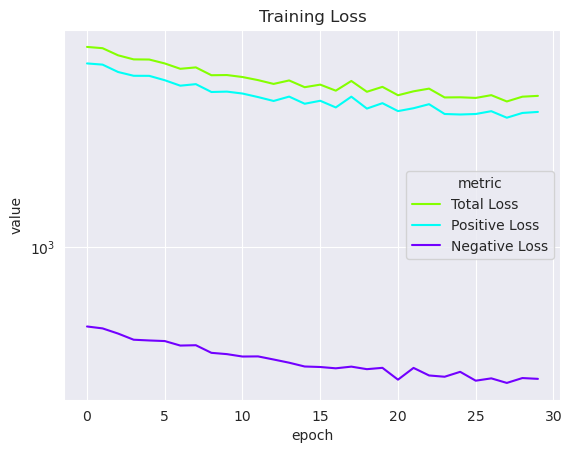

In [19]:
df_train_loss = df_train[df_train['metric'].apply(lambda x: 'Loss' in x)]
ax = sns.lineplot(data=df_train_loss, x='epoch', y='value', hue='metric',
                  palette=sns.color_palette("hsv", 3))

ax.title.set_text('Training Loss')
ax.set_yscale('log')

df_train_loss

,epoch,type,metric,value
4,0,test,Total Loss,50287.750000
5,0,test,Positive Loss,245.750000
6,0,test,Negative Loss,50042.000000
22,0,train,Total Loss,4597.373353
23,0,train,Positive Loss,4053.110000
...,...,...,...,...
730,29,test,Positive Loss,159.700000
731,29,test,Negative Loss,51653.840000
747,29,train,Total Loss,3164.269338
748,29,train,Positive Loss,2799.360000


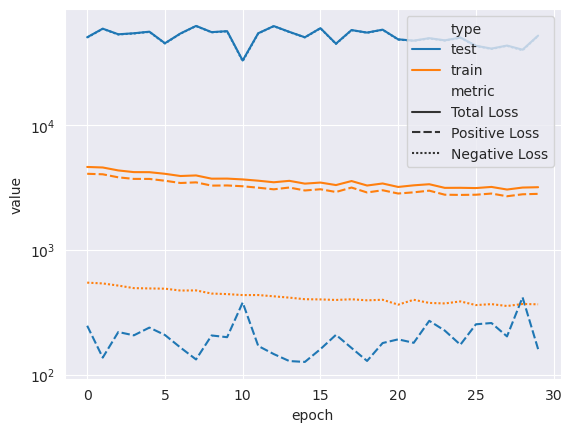

In [26]:
# training vs validation loss

df_all_losses = df[df['metric'].apply(lambda x: 'Loss' in x)]

ax = sns.lineplot(data=df_all_losses, x='epoch', y='value', hue='type', style='metric')

ax.set_yscale('log')

df_all_losses


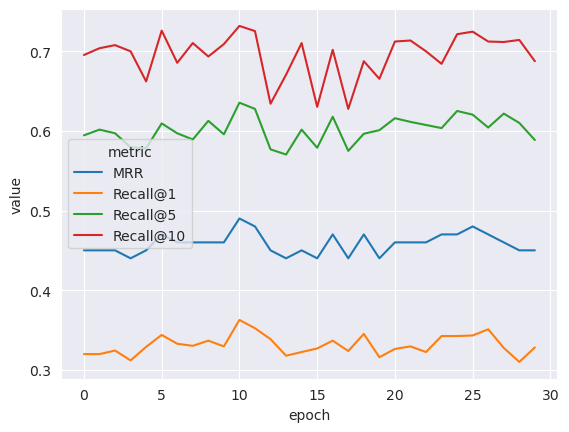

In [21]:

df_test_mrr = df_test[(df_test['metric'] == 'MRR') | (df_test['metric'].apply(lambda x: 'Recall' in x))]
ax = sns.lineplot(data=df_test_mrr, x='epoch', y='value', hue='metric')